# Multiclass classification - Dog Breeds

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.conv_learner import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Data from https://www.kaggle.com/c/dog-breed-identification

## Last time, we did binary classification

In [9]:
def get_1st(path): return glob(f'{path}/*.*')[0]

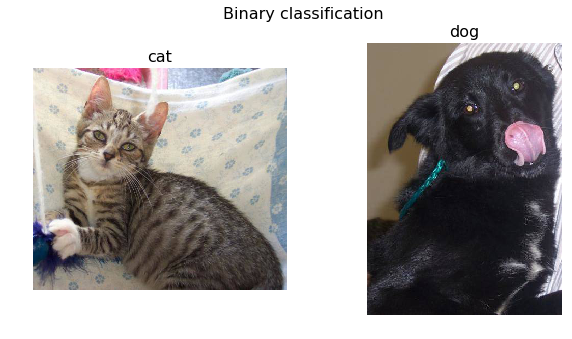

In [10]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Binary classification")

In binary classification each sample belongs to one class or another class. In the cat/dog example, each image is either a *cat* or a *dog*.

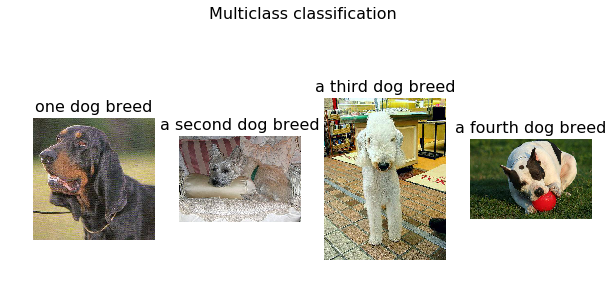

In [11]:
PATH = "data/dogbreed/"
list_paths = [f"{PATH}test/0a0b97441050bba8e733506de4655ea1.jpg", f"{PATH}test/0a0f82d4557f70718efa26f8a8a7773f.jpg", f"{PATH}test/0a3f1f6f5f0ede7ea6e27427994d5f62.jpg", f"{PATH}test/0a7c46f223c4a4b7e7a2f25e8e023d73.jpg"]
titles = ["one dog breed", "a second dog breed", "a third dog breed", "a fourth dog breed"]
plots_from_files(list_paths, titles=titles, maintitle="Multiclass classification")

In multiclass classification there are many possible classes. Each of the four images above is a dog of a different breed.

In [12]:
PATH = 'data/dogbreed/'
sz = 224 
arch = resnext101_64
bs = 58 # higher generates an out of memory error

In [13]:
# sets up the local validation set
label_csv = f'{PATH}labels.csv' #puts the csv file data in labe_csv variable
n = len(list(open(label_csv))) - 1  #  turns variable into a list of rows (header is not counted, which is why we have -1)
val_idxs = get_cv_idxs(n) #returns, by default, a random 20% of the data to use as the validation set

In [14]:
n # gives us the number of data entries in the csv = 10222

10222

In [15]:
len(val_idxs) # gives us the number of data entries we'll use for validation

2044

# Initial Exploration of Data

In [16]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      tmp    train.zip
labels.csv.zip	sample_submission.csv.zip  test.zip  train


In [17]:
label_df = pd.read_csv(label_csv) #reads the csv file into the variable label_df using pandas

In [18]:
label_df.head() # outputs a preview of the label_df variable

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [19]:
# gives us the counts of each breed, sorted from most to least
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False) 

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


## 1. Enable Data Augmentation

In [20]:
# sets up the image transformations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1) #zooms in randomly from normal to 1.1x
# tells the algorithm how to construct the data
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', #have to say where the test set is if we want to submit to Kaggle)
                                    val_idxs=val_idxs, suffix='.jpg', # adds suffix b/c labels don't contain full file names
                                    tfms=tfms, bs=bs)

In [21]:
# grabs the first transformed image
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

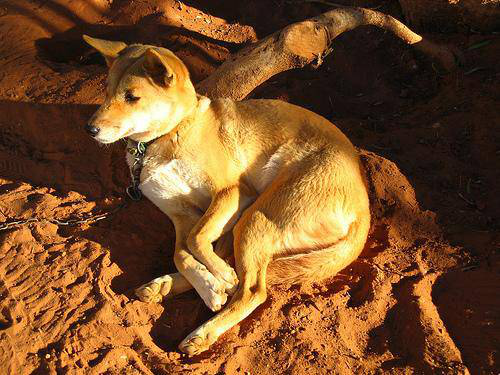

In [22]:
# shows the first transformed image
img = PIL.Image.open(fn); img

In [23]:
img.size

(500, 375)

In [24]:
# creates a dictionary comprehension that maps the name of the file to the size of the file
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [25]:
#turns dictionary into rows and columns
row_sz, col_sz = list(zip(*size_d.values()))

In [26]:
turns the rows and columns into numpy arrays
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [27]:
#first five row sizes for images
row_sz[:5]

array([500, 500, 500, 500, 500])

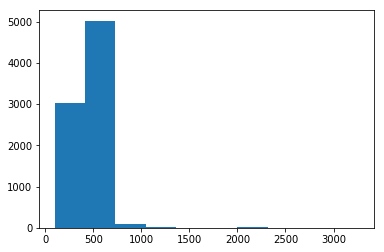

In [28]:
plt.hist(row_sz); # uses matplotlib to show the number of images by their height (rows in image)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

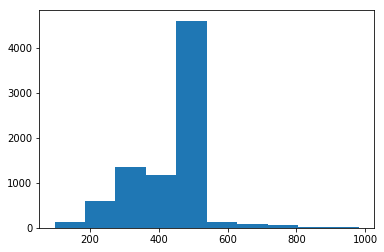

In [29]:
plt.hist(row_sz[row_sz < 1000]) # plots the number of images by vertical size for images smaller than 1000 wide
# vast majority around and under 500 rows high

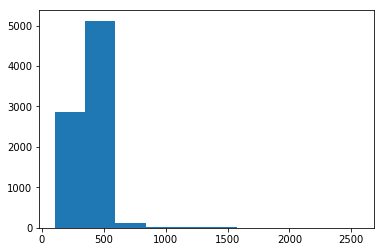

In [30]:
plt.hist(col_sz); # plots the number of images by horizontal size

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

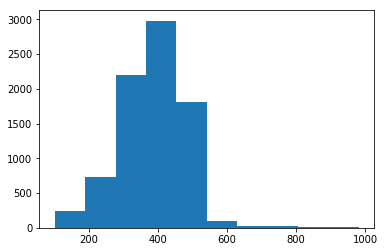

In [31]:
plt.hist(col_sz[col_sz < 1000]) #plots the number of images by horizontal size for images smaller than 1000 tall

In [32]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [33]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial Model

In [34]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp') # reading the jpgs and resizing is slow for big images, so resizing to max 340 saves time

## 1. 1 Precompute

In [35]:
data = get_data(sz, bs)

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

## 2. Trains last layer with precomputed activiations

In [37]:
learn.fit(1e-2, 5) # uses the learning rate that was found with lr.find() (Step 2, below)
# computes at 91.6 % accuracy across 120 classes

epoch      trn_loss   val_loss   accuracy                   
    0      0.952054   0.400348   0.91047   
    1      0.460721   0.340659   0.915362                    
    2      0.320467   0.305597   0.917808                    
    3      0.246613   0.319994   0.916341                    
    4      0.188281   0.304093   0.91683                     



[array([0.30409]), 0.9168297500293082]

## Augment

In [38]:
from sklearn import metrics

In [39]:
data = get_data(sz, bs)

In [40]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [41]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.166693   0.45419    0.89726   
    1      0.531887   0.357923   0.907045                    



[array([0.35792]), 0.9070450123508849]

In [42]:
learn.precompute = False

In [43]:
learn.fit(1e-2, 5, cycle_len=1)
# epoch is one pass through the data
# the cycle_len says how many epocs to run each time the learning rate goes all the way down 
# here, cycle and epoc are the same

epoch      trn_loss   val_loss   accuracy                    
    0      0.452752   0.28376    0.915851  
    1      0.419388   0.265235   0.922211                    
    2      0.376414   0.257705   0.921233                    
    3      0.346907   0.25292    0.920254                    
    4      0.328858   0.24997    0.921233                    



[array([0.24997]), 0.9212328758958268]

In [44]:
learn.save('224_pre')
# saves the algorithm which has been trained on data of 224x224

In [45]:
learn.load('224_pre')

## Increase size

In [46]:
# Now training on bigger images; continuing training on larger images is a very effective way to avoid overfitting.
learn.set_data(get_data(299, bs)) #trains at 299x299 
learn.freeze() # to ensure everything but the last layer is frozen

In [47]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [48]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.333166   0.236175   0.927104  
    1      0.314927   0.231205   0.929061                    
    2      0.292345   0.229951   0.928082                    



[array([0.22995]), 0.9280821997125555]

Validation loss is lower than training loss, which is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find a better parameter.

In [49]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it could zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) #1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.277179   0.219966   0.936399  
    1      0.272537   0.221759   0.92955                     
    2      0.240295   0.218809   0.932485                    
    3      0.244899   0.217451   0.927593                    
    4      0.223529   0.218181   0.930039                    
    5      0.206123   0.212829   0.931996                    
    6      0.199179   0.213997   0.92955                     



[array([0.214]), 0.9295499083347283]

Training loss and validation loss are getting closer and smaller. We are on the right track.

In [50]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)  TTA = Test Time Augmentation
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9339530332681018, 0.20978586642514285)

In [51]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [52]:
learn.save('299_pre')

In [53]:
learn.load('299_pre')

In [54]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epocs   getting a little bit better, still?

epoch      trn_loss   val_loss   accuracy                    
    0      0.203455   0.215906   0.929061  
    1      0.189592   0.215839   0.930528                    



[array([0.21584]), 0.9305283824408358]

In [55]:
learn.save('299_pre')

In [56]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9305283757338552, 0.21454480234474702)

This dataset is very similar to the ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze the convolution layers. 

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [57]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [58]:
data.test_ds.fnames

['test/de084b830010b6107215fef5d4a75b94.jpg',
 'test/6b423ca7020e70eb05732843c5d2bad1.jpg',
 'test/74aa7e201e0e93e13e87b986a7d31839.jpg',
 'test/a079f72193264bc5685e5d28d7372680.jpg',
 'test/583f7580fa5fec1266331fcf83b76fd6.jpg',
 'test/72cd7496a319c832f670fbb8d349217e.jpg',
 'test/ed9e75a553dbb4712addc1638693dc03.jpg',
 'test/6322fa7edb40af844609b4843a89b5fd.jpg',
 'test/d18de4f66f7d2ae8dffb08ec13b9bbc5.jpg',
 'test/8c567325012bf8d7daeff453ec959312.jpg',
 'test/bbecb2e61f07719abe32be3f36b3fac0.jpg',
 'test/7d3a1066521da895f915af31e8e739df.jpg',
 'test/a0256a9577f2e7c6631dd78556e4bab8.jpg',
 'test/87dafc44ed8ae792ea5c341d7cbb6df4.jpg',
 'test/1f2e9080823a6b093e7a4baa668393d2.jpg',
 'test/c65172e587bf02794e5b40f830bcb2af.jpg',
 'test/4f0b2dbc23fdef5f939144f456a62140.jpg',
 'test/a5049952a1a2ea0473e6520db5e4a4fb.jpg',
 'test/685ac2356ad42163b2141a41972e5c54.jpg',
 'test/bd405393e16688e5282b57d92bdbb97b.jpg',
 'test/cbb4039e5a16f80c02f3d188f98beaf7.jpg',
 'test/18cf06b0c6a59c6891bf6f5a42b

In [59]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than vaidation dataset
probs = np.mean(np.exp(log_preds), 0)
# accuracy_np(probs, y), metrics.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [60]:
probs.shape # (n_images, n_classes)

(10357, 120)

In [61]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [63]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [64]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,0.000001,0.000008,3.308387e-07,7.816519e-07,2.418390e-07,1.185909e-07,1.413406e-07,6.738968e-08,2.060671e-08,...,6.314381e-09,9.670543e-09,1.960939e-07,1.230819e-07,1.895632e-06,7.839300e-08,5.114939e-07,0.000003,4.544253e-07,6.381542e-08
1,6b423ca7020e70eb05732843c5d2bad1,0.000047,0.000023,5.353990e-07,2.359586e-06,1.836781e-07,5.526873e-07,2.861858e-07,6.155004e-07,4.102692e-07,...,4.420309e-07,4.731945e-07,8.805508e-08,9.317444e-08,8.898471e-08,4.239717e-08,1.522666e-05,0.000002,1.332451e-06,9.125048e-07
2,74aa7e201e0e93e13e87b986a7d31839,0.000012,0.000009,7.767996e-06,6.719418e-03,2.939631e-05,1.152552e-05,2.924854e-05,3.715237e-05,1.682479e-06,...,1.049482e-05,1.138417e-04,3.449172e-05,1.610363e-05,4.755435e-06,9.816018e-06,6.388744e-06,0.000020,3.485352e-01,9.406293e-06
3,a079f72193264bc5685e5d28d7372680,0.000037,0.000005,3.060963e-06,1.824624e-05,4.677283e-06,8.134278e-07,8.984682e-06,3.741078e-06,1.328186e-06,...,2.449721e-06,4.160930e-06,6.421639e-06,5.175178e-07,3.927884e-06,2.532528e-06,5.163205e-05,0.000014,1.363529e-03,7.964292e-05
4,583f7580fa5fec1266331fcf83b76fd6,0.000035,0.000011,3.646560e-06,1.219855e-05,6.050881e-07,1.015650e-05,1.227430e-07,8.343774e-07,2.035327e-07,...,3.903410e-06,4.606966e-07,2.946074e-07,3.025791e-07,1.867751e-06,6.642987e-07,2.642208e-07,0.000009,1.138342e-05,1.260353e-06


In [65]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [66]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/dogbreed/subm/subm.gz

## Individual prediction

In [67]:
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

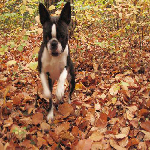

In [70]:
Image.open(PATH + fn).resize((150, 150))

In [71]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [72]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

In [73]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

19

# Steps to train a world-class image classifier
1. Enable data augmentation, and precompute = True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activiations for 1-2 epocs.
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epocs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find again
8. Train full network with cycle_mult=2 until over-fitting

## Quick and dirty (but still very good) image classifier steps
1. Use lr_find() to find highest learning rate where loss is still clearly improving
2. Train last layer with data augmentation(i.e. precompute=False) for 2-3 epocs with cycle_len=1
3. Unfreeze all layers
4. Set earlier layers to 3x-10x lower learnign rate than next higher layer
5. Train full network with cycle-mult=2 until over-fitting